In [14]:
import glob
import math
import os
import sys

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import skimage.measure as ski
from scipy import optimize
import re

from pathlib import Path
cur_dir = Path().resolve()
sys.path.append(str(cur_dir) + "/module")

#### グラフの線種を決定するジェネレータ

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

#### 画像表示用

In [3]:
def imshow_set(fig_ax, *args):
    fig_ax.set_title(args[0])
    fig_ax.imshow(args[1])

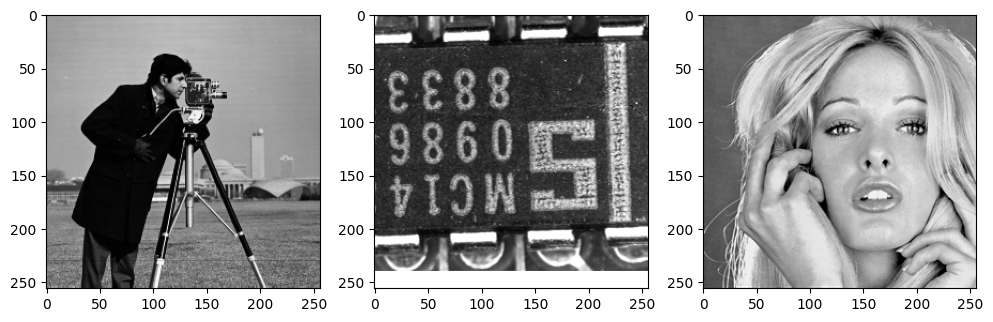

In [25]:
# Get Image file paths
path_list = glob.glob(r'C:\work\Pyhton\jupyter\imageproc\workspace\data\count*#3.png')
img_list = [cv2.imread(path, -1) for path in path_list]

fig, ax = plt.subplots(1, len(img_list), figsize=(12, 5))
for img, a in zip(img_list, ax):
    a.imshow(img, cmap='gray')




In [5]:
# Calculate mean brightness of each image
mean_intensity_list = [np.mean(img) for img in img_list]
print(mean_intensity_list)

# Calculate target intensity 

[118.7244873046875, 97.21095275878906, 134.52931213378906]


[[-846.59424833 -827.05023418 -807.81278646 ...  788.96323054
   808.20067826  827.74469241]
 [-846.5203285  -826.97631435 -807.73886664 ...  789.03715037
   808.27459808  827.81861223]
 [-846.44640867 -826.90239452 -807.66494681 ...  789.1110702
   808.34851791  827.89253206]
 ...
 [-827.89253206 -808.34851791 -789.1110702  ...  807.66494681
   826.90239452  846.44640867]
 [-827.81861223 -808.27459808 -789.03715037 ...  807.73886664
   826.97631435  846.5203285 ]
 [-827.74469241 -808.20067826 -788.96323054 ...  807.81278646
   827.05023418  846.59424833]]


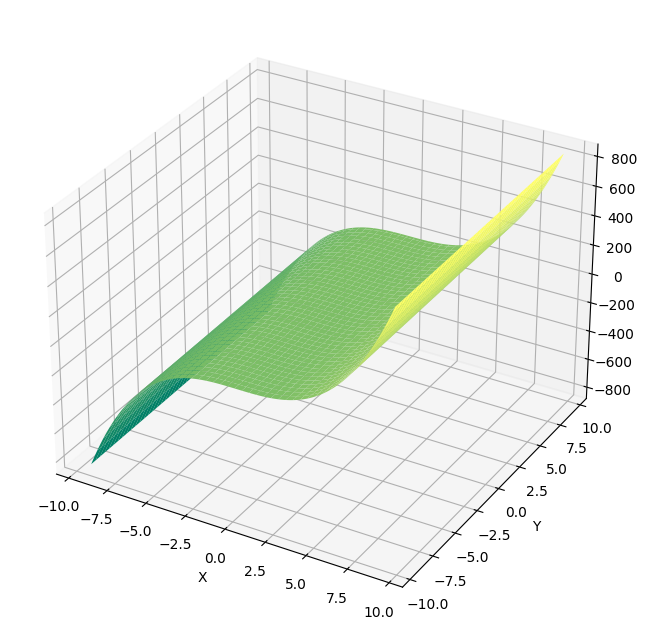

In [24]:
#vertical
start_v = (0, 127)
end_v = (255, 127)
#horizontal
start_h = (127, 0)
end_h = (127, 255)

# lineprofile
# x direction

profile_v_list = [ski.profile_line(img_list[i], start_v, end_v, linewidth=1) for i in range(3)]
profile_h_list = [ski.profile_line(img_list[i], start_h, end_h, linewidth=1) for i in range(3)]

PI = np.pi

x = np.linspace(-3*PI, 3*PI, 256)
y = np.linspace(-3*PI, 3*PI, 256)

X, Y = np.meshgrid(x, y)


# Z = np.cos(X/PI) * np.sin(Y/PI)
Z = X*X*X + Y

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.plot_surface(X, Y, Z, cmap='summer')

print(Z)
# y direction

# x = profile_h_list[0]
# diff_x = np.diff(x)
# # ispeak_list = (diff_x[1:] * diff_x[:-1] < 0) & (diff_x > 0)




# # draw graph
# fig, ax = plt.subplots()
# ax.plot(x, color='red', label='horizontal')
# ax.plot(diff_x, color='blue', label='diff')
# ax.legend()

In [9]:
# 1. 画像の読み込みと輝度分布の取得
# 仮想的な画像を作成する例として、ランダムな値で100x100の画像を作成します。
# 実際の画像を使用する場合は、適切に読み込んでください。
image = np.random.rand(100, 100) * 255

def fit_plane(point_cloud):
    """
    入力
        point_cloud : xyzのリストnumpy.array型
    出力
        n_vec : 法線ベクトルの向き(単位ベクトル)
        com : 重心近似平面が通る点
    """

    com = np.sum(point_cloud, axis=0) / len(point_cloud)
    # 重心を計算
    q = point_cloud - com
    # 重心を原点に移動し、同様に全点群を平行移動する  pythonのブロードキャスト機能使用
    Q = np.dot(q.T, q)
    # 3x3行列を計算する 行列計算で和の形になるため総和になる
    la, vectors = np.linalg.eig(Q)
    # 固有値、固有ベクトルを計算　固有ベクトルは縦のベクトルが横に並ぶ形式
    n_vec = vectors.T[np.argmin(la)]
    # 固有値が最小となるベクトルの成分を抽出

    return n_vec, com


# 2. 輝度分布の2変数関数のフィッティング
# 2変数関数として輝度分布を表現するため、2つの変数X, Yを作成します。
x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
x_data = x.ravel()
y_data = y.ravel()
z_data = image.ravel()

# フィッティング関数の定義
def plane_func(params, x, y):
    a, b, c = params
    return a * x + b * y + c

# 最適化の初期値
initial_guess = [0.1, 0.1, 0.1]

# 最適化の実行
# params, _ = optimize.curve_fit(plane_func, (x_data, y_data), z_data, p0=initial_guess)

# # フィッティング結果から回帰平面を取得
# a_fit, b_fit, c_fit = params

# # 3. ピークの検出
# # 例として、ピークは輝度が最大の点とします。
# # 実際には、信号処理の手法を用いてピーク検出を行うこともあります。
# peak_x, peak_y = np.unravel_index(np.argmax(image), image.shape)
# peak_intensity = image[peak_x, peak_y]

# # 4. 回帰平面のプロットとピークのプロット
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # 回帰平面のプロット
# ax.scatter(x_data, y_data, z_data, c='b', marker='o', label='Data Points')
# fit_surface = a_fit * x + b_fit * y + c_fit
# ax.plot_surface(x, y, fit_surface, alpha=0.5, color='r', label='Fitted Plane')

# # ピークのプロット
# ax.scatter(peak_x, peak_y, peak_intensity, c='g', marker='x', s=100, label='Peak')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Intensity')
# plt.legend()
# plt.show()
